# Matching Code

This code is to implement and test different matching methods

Explain why we did matching? plot average distances of matching. Think of a KPI. Illustrate with one graph or visualisation, this can be a good distance measure, then back up with literature, the ECB article.

Comapre the coverage, do we have more bonds than taking a very strict matching algorithm, Create a table with different matching algorithms and the results. Show that we used different matching methods.

emphasise that the data is scarce, we do not want to lose too much data, get better results with broader scope. 

for any given green bond, take the match which has the smallest distance
take average distance. group by bonds and conventional bond unique name, compute mean average distance.
then take smallest pair in average.

weight the coupon in the distance measure a bit less, put more weight on the days to maturity.
include emission date measure. 

Show this in our analysis.

test YTM vs. Z-spread.

• Aggregate bonds by ISIN per company (since each bond appears over multiple dates) so that matching is done at the bond‐level rather than per DateTime row.
• Compute a custom distance using three features (Coupon, days‐to‐maturity, and an emission year extracted from your emission columns). We then down‐weight Coupon (here by a factor of 0.5) so that differences in days‐to‐maturity and emission year matter more.
• Perform one‐to‐one matching by solving a bipartite assignment (using the Hungarian algorithm via SciPy’s linear_sum_assignment) so that each green bond is matched with one conventional bond (and vice‐versa as far as possible).
• After matching, we merge the matched bond pairs back with the original time‐series data (using DateTime) to compute the YTM difference (green minus conventional) on the dates where both bonds are observed.
• Finally, we run a regression of the YTM difference on the matching “distance” as an example. (You could, of course, include additional controls or test against the Z‑spread if available.)
• A bar chart is produced as a key performance indicator (KPI) visualization of average matching distance per company. This type of plot can serve as a “good distance measure” and can be compared with similar measures in the literature (for example, see the ECB article on matching methods).

Why Matching?
 Matching green bonds with conventional ones allows us to form comparable pairs so that differences in yield‐to‐maturity (YTM) can be more reliably attributed to “green” factors rather than differences in bond characteristics. A good distance measure (here the Euclidean distance between standardized features) helps ensure that the matched pairs are similar. Researchers (see, for example, ECB publications) have used similar approaches to control for confounding variables.

Visualization (KPI):
 The bar chart of average matching distance per company provides an intuitive measure of how “close” the pairs are. A lower average distance indicates better matches. This can be used as a key performance indicator when comparing different matching methods.

Coverage vs. Stringency:
 By comparing the number of matches and average distances across methods (as illustrated in the optional summary table), one can demonstrate that while stricter matching may yield a lower average distance (better quality), it might also lead to a smaller sample. In our context—where data are scarce—a broader matching criterion (one-to-one matching as shown) may be preferable.

Regression Analysis:
 After matching, the code merges the time series data so that for each bond pair we have YTM observations over time. The regression of the YTM difference on the matching distance (and any other covariates you may add) tests whether the “quality” of the match relates to the observed YTM spread. You could extend this analysis to test against the Z‑spread as well.

Stacked Panel Regression:
The new function prepare_stacked_regression_data creates a dataset where each time-series observation from the green and conventional bonds is kept (with an indicator is_green and other characteristics such as Coupon and maturity). We then run a panel regression (using clustered standard errors by bond pair) to see if, after controlling for these factors, there is a significant difference in YTM between green and conventional bonds.

# Cleaned Code

## 1 - Imports

In [2]:
# Import with correcting the dataset parsing
import pandas as pd
import numpy as np

def parse_numeric(value):
    """
    Convert a string like '3,08%', '3.08', '3,08', '3.1%' to a float.
    Removes trailing '%' if present, replaces commas with dots,
    and attempts float conversion. Returns NaN on failure.
    """
    if pd.isna(value):
        return np.nan
    # Convert to string in case it is not
    value_str = str(value).strip()
    # Remove percentage sign if present
    value_str = value_str.replace('%', '')
    # Replace commas with dots
    value_str = value_str.replace(',', '.')
    # Attempt to convert to float
    try:
        return float(value_str)
    except ValueError:
        return np.nan

# Read your CSV file
url = "https://raw.githubusercontent.com/Fijiman001/EGR-Empirical-Project/refs/heads/main/data/Final%20data%20for%20the%20study/df_final_7.csv"
df = pd.read_csv(url)

# Now parse the columns of interest. For example, if you have columns:
# 'YTM', 'Coupon', 'Modified Duration', etc.
df['YTM'] = df['YTM'].apply(parse_numeric)
df['Coupon'] = df['Coupon'].apply(parse_numeric)
df['Modified Duration'] = df['Modified Duration'].apply(parse_numeric) / 1000

# Now df['YTM'], df['Coupon'], and df['Modified Duration'] will be numeric.
print(df[['YTM','Coupon','Modified Duration']].head(10))

    YTM  Coupon  Modified Duration
0  2.46   0.375              2.405
1  2.50   0.375              2.405
2  2.47   0.375              2.405
3  2.51   0.375              2.405
4  2.55   0.375              2.405
5  2.52   0.375              2.405
6  2.57   0.375              2.405
7  2.53   0.375              2.405
8  2.52   0.375              2.405
9  2.55   0.375              2.405


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional: Configure matplotlib for inline plotting
%matplotlib inline

In [4]:
print(df.columns)

# The amount of companies with more than 1 unique ISIN
companies = df.groupby('Company')['ISIN'].nunique()
companies = companies[companies > 1]
print(companies)

# Companies with both 1 green and one conventional bond, 'is_green needs to be both 0 and 1
companies = df.groupby('Company')['is_green'].nunique()
companies = companies[companies == 2]
print(companies)

# of those companies, we look at the amount of bonds available
matching_companies = {}
for company in companies.index:
    group = df[df['Company'] == company]
    matched = group['ISIN'].nunique()
    print(f"{company}: {matched} unique ISINs")
    matching_companies[company] = matched
print("list of issuers with both green and conventional bonds we will be analysing")
print(list(matching_companies.keys()))

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')
Company
a2a s p a                                3
ab svensk exportkredit                   2
acea s p a                               2
amprion gmbh                     

we keep firms that have both a green and conventional bond in the data set, we will be using those to create a subset of the data that we will be using to run our analysis on

In [5]:
df_matched = df[df['Company'].isin(matching_companies.keys())]
# Dimensions of df_matched, the amount of unique ISINs, and the amount of Companies
print(df_matched.shape)
print(df_matched['ISIN'].nunique())
print(df_matched['Company'].nunique())
# amount of bonds that are green
print(df_matched[df_matched['is_green'] == 1]['ISIN'].nunique())

(6588, 44)
288
35
100


the matched data set only has 6588 rows, with 288 unique ISINS and 35 unique emitters. of those 288 bonds, 100 bonds are green
given this subset of data, we create our distance measure to find the closest comparable bonds to the green bonds

In [6]:
# Overview of the currencies used in the dataset
df_matched['Emissionswährung'].unique()
for currency in df_matched['Emissionswährung'].unique():
    print(currency)
    print(df[df['Emissionswährung'] == currency]['ISIN'].nunique())

EUR
370
USD
27
CAD
3
BRL
2
COP
1
GBP
5
NZD
1
NOK
1
HUF
1
ZAR
1
AUD
2
TRY
1


we will only keep EUR bonds

In [7]:
# keeping only EUR
df_matched = df_matched[df_matched['Emissionswährung'] == 'EUR']
print(df_matched.shape)

(5948, 44)


In [8]:
print(df_matched.columns)
print(df_matched.head())

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')
                   Name Clean_Company_Maturity     WKN  \
0  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   
1  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR

## 2 - Matching Functions
One-to-One Matching

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

def get_emission_year(row, emission_cols):
    """
    Extract the emission year from the indicator columns.
    Assumes exactly one of the 'Emission_year_' columns is True.
    """
    for col in emission_cols:
        if row[col]:
            # Remove potential trailing '.0' and convert to integer
            return int(col.split('_')[-1].split('.')[0])
    return np.nan

def match_green_bonds_one_to_one_all_obs_with_time(df, time_weight=1.0):
    """
    For each company, perform one-to-one matching between green and conventional bond observations
    using all available time series data. In addition to the original matching features (Coupon,
    days_to_maturity, emission_year), this function includes a time feature derived from DateTime.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with bond data containing at least the following columns:
            'Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green', 'YTM',
        plus columns starting with 'Emission_year_' indicating the bond’s emission year.
    time_weight : float, default 1.0
        Weight to apply to the standardized time feature. Increase to put more emphasis on matching
        observations that are closer in time.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with matched pairs. Each row contains bond details for a green and a conventional bond,
        including the DateTime and YTM values, plus the computed matching distance.
    """
    # Convert key columns to numeric
    df['YTM'] = pd.to_numeric(df['YTM'], errors='coerce')
    df['Coupon'] = pd.to_numeric(df['Coupon'], errors='coerce')
    df['days_to_maturity'] = pd.to_numeric(df['days_to_maturity'], errors='coerce')
    df['Modified Duration'] = pd.to_numeric(df['Modified Duration'], errors='coerce')
    df['Last Price'] = pd.to_numeric(df['Last Price'], errors='coerce')
    
    # Compute emission_year from columns that start with 'Emission_year_'
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df = df.copy()
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    # Convert DateTime to a numeric value.
    # Here we convert DateTime to days since epoch.
    df['Time'] = pd.to_datetime(df['DateTime']).astype(np.int64) / (1e9 * 3600 * 24)
    
    # Sort by DateTime to preserve the time series order
    df_sorted = df.sort_values('DateTime')
    
    matched_results = []
    
    for company in df_sorted['Company'].unique():
        comp_df = df_sorted[df_sorted['Company'] == company]
        if not (comp_df['is_green'].eq(1).any() and comp_df['is_green'].eq(0).any()):
            continue
        
        green_df = comp_df[comp_df['is_green'] == 1].reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].reset_index(drop=True)
        
        # Define features for matching (note that DateTime is now represented by "Time")
        features = ['Coupon', 'days_to_maturity', 'emission_year', 'Time']
        combined_features = comp_df[features]
        
        means = combined_features.mean()
        stds = combined_features.std()
        
        green_scaled = ((green_df[features] - means) / stds).reset_index(drop=True)
        conv_scaled = ((conv_df[features] - means) / stds).reset_index(drop=True)
        
        # Down-weight coupon differences to reduce their influence on matching
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        # Optionally adjust the time difference weight
        green_scaled['Time'] *= time_weight
        conv_scaled['Time'] *= time_weight
        
        # Compute the Euclidean distance matrix between green and conventional observations
        green_mat = green_scaled.values
        conv_mat = conv_scaled.values
        distance_matrix = np.sqrt(((green_mat[:, None, :] - conv_mat[None, :, :]) ** 2).sum(axis=2))
        
        # Solve the assignment problem using the Hungarian algorithm for one-to-one matching
        row_ind, col_ind = linear_sum_assignment(distance_matrix)
        
        for r, c in zip(row_ind, col_ind):
            green_obs = green_df.iloc[r]
            conv_obs = conv_df.iloc[c]
            matched_results.append({
                'Company': company,
                'Green_Bond_ISIN': green_obs['ISIN'],
                'Green_Bond_Name': green_obs.get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_obs['Coupon'],
                'Green_Bond_Maturity': green_obs['days_to_maturity'],
                'Green_Bond_Emission_Year': green_obs['emission_year'],
                'Green_Bond_YTM': green_obs['YTM'],
                'Green_Bond_Price': green_obs['Last Price'],
                'Green_Bond_Mdur': green_obs['Modified Duration'],
                'Green_Bond_DateTime': green_obs['DateTime'],
                'Conv_Bond_ISIN': conv_obs['ISIN'],
                'Conv_Bond_Name': conv_obs.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_obs['Coupon'],
                'Conv_Bond_Maturity': conv_obs['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_obs['emission_year'],
                'Conv_Bond_YTM': conv_obs['YTM'],
                'Conv_Bond_Price': conv_obs['Last Price'],
                'Conv_Bond_Mdur': conv_obs['Modified Duration'],
                'Conv_Bond_DateTime': conv_obs['DateTime'],
                'Matching_Distance': distance_matrix[r, c]
            })
    
    return pd.DataFrame(matched_results)

In [10]:
# Run the matching function on your prepared DataFrame (e.g., df_matched)
matched_df = match_green_bonds_one_to_one_all_obs_with_time(df_matched)

In [11]:
# Create a new column for the YTM difference (green bond YTM minus conventional bond YTM)
matched_df['YTM_diff'] = matched_df['Green_Bond_YTM'] - matched_df['Conv_Bond_YTM']
matched_df['Mdur_diff'] = matched_df['Green_Bond_Mdur'] - matched_df['Conv_Bond_Mdur']
matched_df['Coupon_diff'] = matched_df['Green_Bond_Coupon'] - matched_df['Conv_Bond_Coupon']
matched_df['days_to_maturity_diff'] = matched_df['Green_Bond_Maturity'] - matched_df['Conv_Bond_Maturity']
print(matched_df.head())
print(matched_df['YTM_diff'].describe())

  Company Green_Bond_ISIN      Green_Bond_Name  Green_Bond_Coupon  \
0  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
1  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
2  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
3  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
4  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   

   Green_Bond_Maturity  Green_Bond_Emission_Year  Green_Bond_YTM  \
0                 1503                      2023            2.94   
1                 1503                      2023            2.96   
2                 1502                      2023            2.99   
3                 1502                      2023            3.01   
4                 1502                      2023            3.03   

   Green_Bond_Price  Green_Bond_Mdur   Green_Bond_DateTime  ...  \
0            102.67            3.362  2025-01-02T13:00:00Z  ...   
1            102.59            3.362  2025

Matching using a distance measure based upon coupon, seniority, difference between datetime, and emission year gives an average difference in yield of: $-0.170393$
Below we run a regression: we cluster the standard errors by issuer (using the "Company" variable) to account for the possibility that observations from the same issuer may have correlated error terms.

Clustering the errors by issuer (i.e. by the "Company" column) allows the regression to adjust for potential correlations in the error terms among observations coming from the same issuer. In our context, this means that if multiple matched pairs come from the same company, their errors might be correlated due to unobserved company-specific factors. Standard OLS assumes that errors are independent across all observations, so if this assumption is violated, standard errors (and therefore inference such as t-statistics and p-values) may be misleading.

By clustering on issuer, we let the model relax the independence assumption within each company group while still assuming independence across companies. This generally results in robust (and often larger) standard errors, leading to more reliable hypothesis tests regarding the effect of Matching_Distance on the yield difference.

In [12]:
# Looking at na values
matched_df[['Matching_Distance', 'Mdur_diff', 'Coupon_diff', 'days_to_maturity_diff']].isna().sum()

Matching_Distance         0
Mdur_diff                69
Coupon_diff               0
days_to_maturity_diff     0
dtype: int64

In [13]:
import statsmodels.api as sm
# Define the independent variable (with a constant) and the dependent variable
# X = sm.add_constant(matched_df[['Matching_Distance', 'Mdur_diff', 'Coupon_diff', 'days_to_maturity_diff']])
X = sm.add_constant(matched_df[['Matching_Distance', 'Coupon_diff', 'days_to_maturity_diff']])
Y = matched_df['YTM_diff']

# Fit the OLS model and cluster standard errors by 'Company' (issuer)
model = sm.OLS(Y, X).fit()
model_clustered = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': matched_df['Company']})
print(model.summary())
print(model_clustered.summary())

                            OLS Regression Results                            
Dep. Variable:               YTM_diff   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     248.1
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          4.19e-114
Time:                        08:35:40   Log-Likelihood:                -338.75
No. Observations:                 812   AIC:                             685.5
Df Residuals:                     808   BIC:                             704.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.12

## Plotting average YTM difference throughout time and more

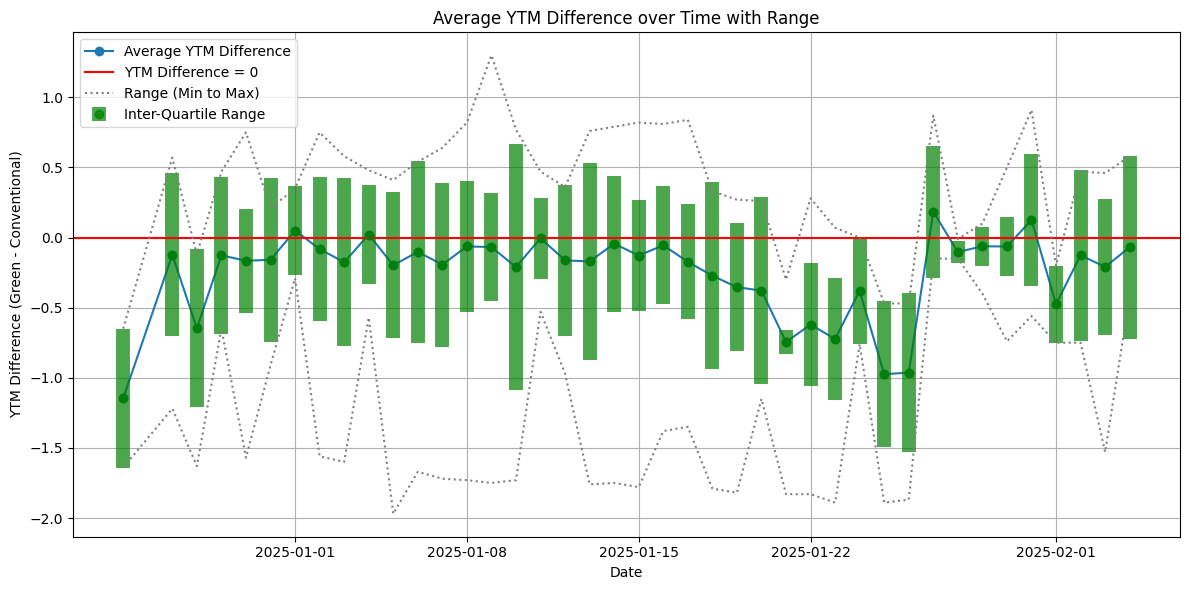

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the DateTime columns are datetime objects
matched_df['Green_Bond_DateTime'] = pd.to_datetime(matched_df['Green_Bond_DateTime'])
matched_df['Conv_Bond_DateTime'] = pd.to_datetime(matched_df['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
# Convert to int64 (nanoseconds since epoch), average, then convert back to datetime
matched_df['pair_date'] = pd.to_datetime(
    (matched_df['Green_Bond_DateTime'].astype(np.int64) + matched_df['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily averages, extract the date portion (drop the time)
matched_df['pair_date'] = matched_df['pair_date'].dt.date

# Group by the pair_date and calculate the average YTM difference for each day
daily_stats = matched_df.groupby('pair_date').agg(
	mean=('YTM_diff', 'mean'),
	min=('YTM_diff', 'min'),
	max=('YTM_diff', 'max'),
	quant75=('YTM_diff', lambda x: x.quantile(0.75)),
	quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()
iqr = daily_stats['quant75'] - daily_stats['quant25']

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# Create the plot with mean and range
plt.figure(figsize=(12, 6))

# Plot the average line
plt.plot(daily_stats['pair_date'], daily_stats['mean'], marker='o', linestyle='-', label='Average YTM Difference')

# Plot the range as a boxplot line
plt.errorbar(daily_stats['pair_date'], daily_stats['min'], linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats['pair_date'], daily_stats['max'], linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats['pair_date'], daily_stats['mean'], yerr = iqr, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)

# Adding y = 0
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional)')
plt.title('Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# get list of all dates in the data set
print(daily_stats[daily_stats['pair_date']=='2025-01-25'])
# we order the data by min
daily_stats = daily_stats.sort_values('min')
daily_stats.head()

    pair_date   mean   min   max
30 2025-01-25 -0.975 -1.89 -0.47


,pair_date,mean,min,max
10,2025-01-05,-0.197391,-1.97,0.41
30,2025-01-25,-0.975000,-1.89,-0.47
28,2025-01-23,-0.723333,-1.89,0.07
31,2025-01-26,-0.962500,-1.87,-0.47
27,2025-01-22,-0.620667,-1.83,0.28


We investigate what is causing these extreme values

In [16]:
extreme_dates = daily_stats.head()['pair_date']
print(extreme_dates)

# Ensure the DateTime columns are datetime objects
matched_df['Green_Bond_DateTime'] = pd.to_datetime(matched_df['Green_Bond_DateTime'])
matched_df['Conv_Bond_DateTime'] = pd.to_datetime(matched_df['Conv_Bond_DateTime'])
matched_df['pair_date'] = pd.to_datetime(
    (matched_df['Green_Bond_DateTime'].astype(np.int64) + matched_df['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# looking at the df we used to calculate the average yields, only looking at the first extreme date: 2025-01-14
# matched_df[matched_df['pair_date'] == extreme_dates.iloc[0]].sort_values('YTM_diff')

# we want to only extract the date from pair_date from the matched_df, it contains the date and time, but we want to match by date only
matched_df['pair_date'] = matched_df['pair_date'].dt.date
matched_df['pair_date'] = pd.to_datetime(matched_df['pair_date'])
matched_df[matched_df['pair_date'] == '2025-01-25'].sort_values('YTM_diff').head()

10   2025-01-05
30   2025-01-25
28   2025-01-23
31   2025-01-26
27   2025-01-22
Name: pair_date, dtype: datetime64[ns]


,Company,Green_Bond_ISIN,Green_Bond_Name,Green_Bond_Coupon,Green_Bond_Maturity,Green_Bond_Emission_Year,Green_Bond_YTM,Green_Bond_Price,Green_Bond_Mdur,Green_Bond_DateTime,...,Conv_Bond_YTM,Conv_Bond_Price,Conv_Bond_Mdur,Conv_Bond_DateTime,Matching_Distance,YTM_diff,Mdur_diff,Coupon_diff,days_to_maturity_diff,pair_date
359,raiffeisen bank international ag,xs2353473692,"Raiffeisen Bank International AG 1,375% 21/33",1.375,3056,2021,2.40,92.22,NaN,2025-02-03 10:01:00+00:00,...,4.29,100.89,NaN,2025-01-16 17:00:00+00:00,3.573818,-1.89,NaN,-3.375,2316,2025-01-25
335,mizuho financial group inc,xs2528323780,"Mizuho Financial Group Inc. 3,49% 22/27",3.490,944,2022,2.71,101.94,2.292,2025-02-03 10:01:00+00:00,...,3.59,90.45,5.253,2025-01-16 17:00:00+00:00,3.122337,-0.88,-2.961,1.394,-1695,2025-01-25
550,caisse francaise de financement local,fr001400dxr9,"Caisse Francaise de Financement Local 3,125% 2...",3.125,1016,2022,2.58,101.46,2.467,2025-02-03 10:01:00+00:00,...,3.24,99.08,5.991,2025-01-16 09:26:00+00:00,3.437942,-0.66,-3.524,0.000,-2218,2025-01-25
334,mizuho financial group inc,xs2672418055,"Mizuho Financial Group Inc. 4,608% 23/30",4.608,2032,2023,3.14,107.54,4.239,2025-02-03 10:01:00+00:00,...,3.61,90.31,5.253,2025-01-16 13:00:00+00:00,3.323706,-0.47,-1.014,2.512,-607,2025-01-25


Before removing the observations of non euro currencies we had problems of bonds denoted in other currencies due to the large differences in yields sometimes present. We see the problem is caused by a bond denominated in turkish lira TRY, from "Instituto de Credito Oficial 29% 24/33" so we drop this one, and repeat the process for other extreme outliers

In [17]:
# I drop the bond from "Instituto de Credito Oficial 29% 24/33" as it is an outlier
#matched_df = matched_df[matched_df['Green_Bond_Name'] != 'Instituto de Credito Oficial 29% 24/33']
# and repeat the same for the other extreme dates: 2025-01-30
# matched_df = matched_df[matched_df['Green_Bond_Name'] != 'International Finance Corp. 11.5% 25/30']
# matched_df = matched_df[matched_df['Green_Bond_Name'] != 'International Finance Corp. 0,000% 20/30']
# matched_df[matched_df['pair_date'] == '2024-12-30'].sort_values('YTM_diff').head()

### Plot average distance measure and number of observations over time

we visualise the amount of observations per date and the mean and weighted mean distance measure over time

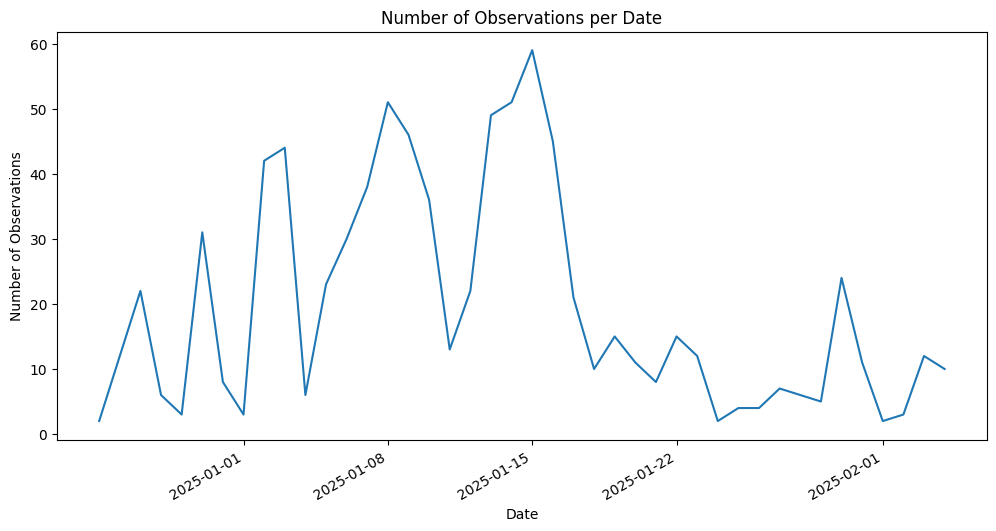

In [ ]:
# I want to plot the amount of observations for each date
date_counts = matched_df['pair_date'].value_counts().sort_index()

# I also want to add mean weighted distance measure over time to the plot
date_counts = matched_df.groupby('pair_date')['Matching_Distance'].mean().sort_index()
date_counts = matched_df

plot = date_counts.plot(kind='line', figsize=(12, 6))
plot.set_xlabel('Date')
plot.set_ylabel('Number of Observations')
plot.set_title('Number of Observations per Date')
plt.show()

## Corrected Plot of YTM_Difference over time

To compare we not weight the differences in YTM between green and conventional bonds by the distance measure, more concretely, rescaling them. 
We weight the bond pairs by $ 1 / (1 + MatchingDistance)$ giving a larger weight to bonds that are closer in characteristics.

C:\Users\Alex\AppData\Local\Temp\ipykernel_8092\1183706070.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


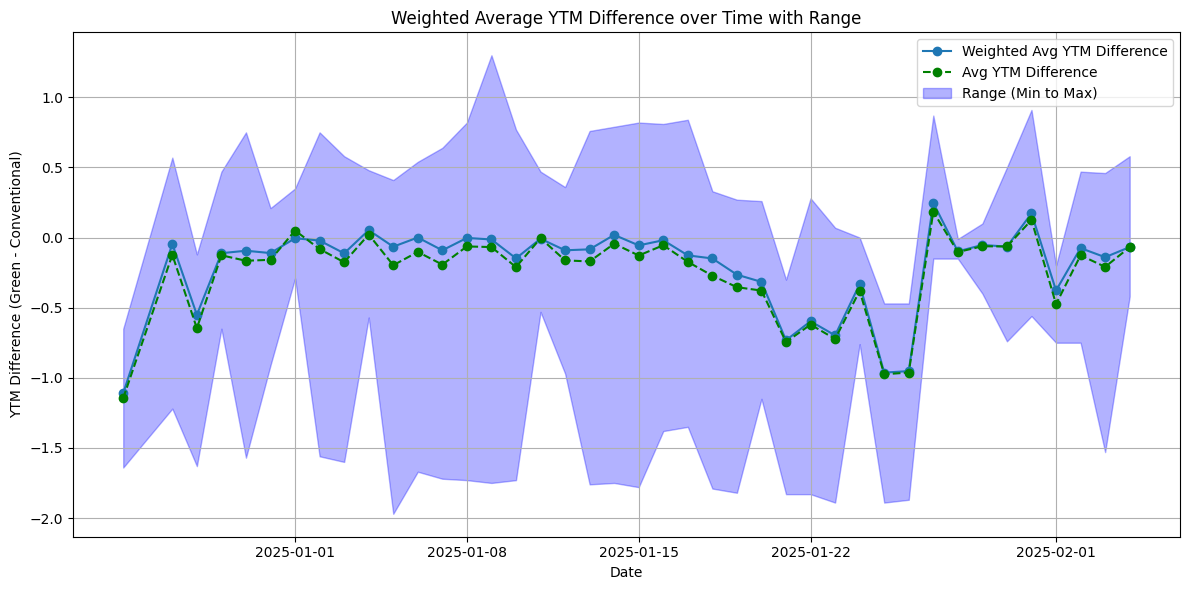

In [ ]:
# Ensure the DateTime columns are datetime objects
matched_df['Green_Bond_DateTime'] = pd.to_datetime(matched_df['Green_Bond_DateTime'])
matched_df['Conv_Bond_DateTime'] = pd.to_datetime(matched_df['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
matched_df['pair_date'] = pd.to_datetime(
    (matched_df['Green_Bond_DateTime'].astype(np.int64) + matched_df['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily data, drop the time portion
matched_df['pair_date'] = matched_df['pair_date'].dt.date

# ------------------------------------------------------------------------------
#    weight = 1 / (1 + Matching_Distance)
# ------------------------------------------------------------------------------
matched_df['weight'] = 1 / (1 + matched_df['Matching_Distance'])

# ------------------------------------------------------------------------------
# 2) Compute a weighted average YTM_diff for each date
# ------------------------------------------------------------------------------

def weighted_avg(values, weights):
    """Compute the weighted average of 'values' using 'weights'."""
    return np.average(values, weights=weights)

# We also keep track of min and max for a shaded range plot
daily_stats = (
    matched_df
    .groupby('pair_date')
    .apply(lambda group: pd.Series({
        'weighted_mean': weighted_avg(group['YTM_diff'], group['weight']),
        'mean': group['YTM_diff'].mean(),
        'min': group['YTM_diff'].min(),
        'max': group['YTM_diff'].max()
    }))
    .reset_index()
)

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# ------------------------------------------------------------------------------
# 3) Plot the weighted average line along with the min-max range
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

# Weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['weighted_mean'],
    marker='o', linestyle='-',
    label='Weighted Avg YTM Difference'
)

# Previous non-weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['mean'],
    marker='o', linestyle='--',
    label='Avg YTM Difference',
    color='green'
)

# Shaded area for min-max range
plt.fill_between(
    daily_stats['pair_date'],
    daily_stats['min'],
    daily_stats['max'],
    alpha=0.3, color='blue',
    label='Range (Min to Max)'
)

# # Plot the average line
# plt.plot(daily_stats['pair_date'], daily_stats['mean'], marker='o', linestyle='-', label='Average YTM Difference')

# # Plot the range as a boxplot line
# plt.errorbar(daily_stats['pair_date'], daily_stats['min'], linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
# plt.errorbar(daily_stats['pair_date'], daily_stats['max'], linestyle=':', color='grey')
# # Add interquartile range (IQR) as a green box around the mean
# plt.errorbar(daily_stats['pair_date'], daily_stats['mean'], yerr = iqr, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)

# # Adding y = 0
# plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')
# plt.xlabel('Date')
# plt.ylabel('YTM Difference (Green - Conventional)')
# plt.title('Average YTM Difference over Time with Range')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional)')
plt.title('Weighted Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [240]:
print(matched_df[['Matching_Distance', 'YTM_diff']].isna().sum())
# Find a specific date that shows NaN for the weighted_mean
problematic_date = daily_stats.loc[daily_stats['weighted_mean'].isna(), 'pair_date'].iloc[0]

# Look at the rows for that date
group = matched_df[matched_df['pair_date'] == problematic_date]
print(group[['YTM_diff', 'Matching_Distance', 'weight']])

Matching_Distance     0
YTM_diff             24
dtype: int64
Empty DataFrame
Columns: [YTM_diff, Matching_Distance, weight]
Index: []


## TO-DO?: Winsorising and reformating
I delete the extreme value to have a better look at the dynamics

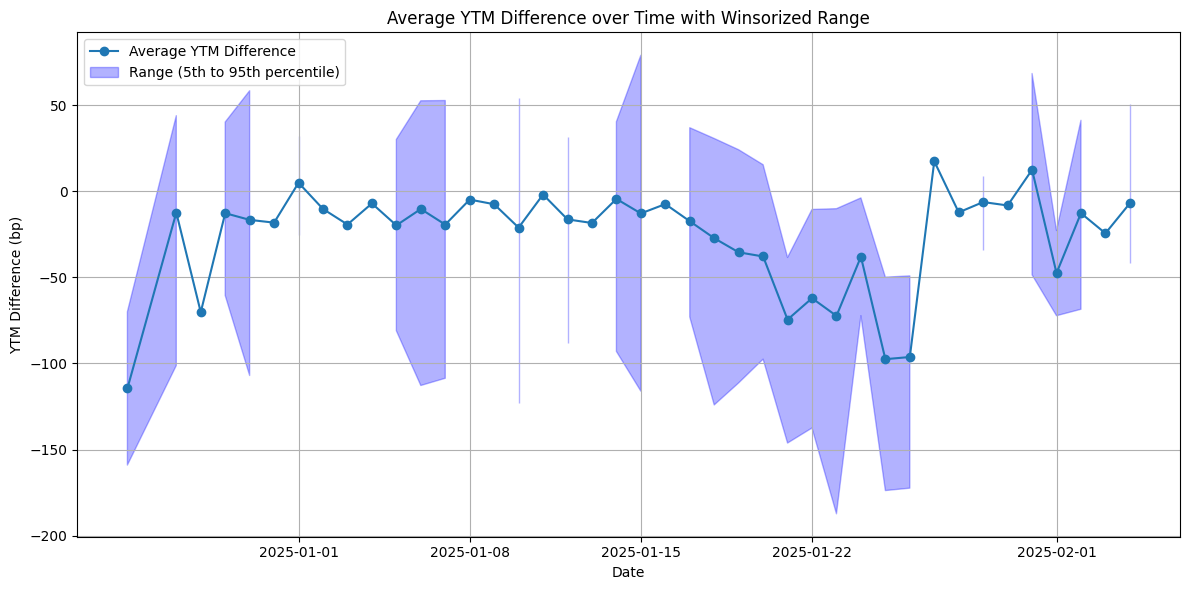

In [189]:
# Remove the extreme values in the range and convert the YTM_diff from % to basis points by doing * 100
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the DateTime columns are datetime objects
matched_df['Green_Bond_DateTime'] = pd.to_datetime(matched_df['Green_Bond_DateTime'])
matched_df['Conv_Bond_DateTime'] = pd.to_datetime(matched_df['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
# Convert to int64 (nanoseconds since epoch), average, then convert back to datetime
matched_df['pair_date'] = pd.to_datetime(
    (matched_df['Green_Bond_DateTime'].astype(np.int64) + matched_df['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily averages, extract the date portion (drop the time)
matched_df['pair_date'] = matched_df['pair_date'].dt.date

# Convert YTM_diff from percentage to basis points (1% = 100 bp)
matched_df['YTM_diff'] = matched_df['YTM_diff'] * 100

# Group by the pair_date and calculate:
# - the average YTM difference (mean)
# - the lower bound as the 5th percentile (removes extreme low values)
# - the upper bound as the 95th percentile (removes extreme high values)
daily_stats = matched_df.groupby('pair_date')['YTM_diff'].agg(
    mean='mean',
    lower=lambda x: np.percentile(x, 5),
    upper=lambda x: np.percentile(x, 95)
).reset_index()

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# Create the plot with mean and the winsorized range
plt.figure(figsize=(12, 6))

# Plot the average line
plt.plot(daily_stats['pair_date'], daily_stats['mean'], marker='o', linestyle='-', label='Average YTM Difference')

# Plot the range as a shaded area (5th to 95th percentiles)
plt.fill_between(daily_stats['pair_date'], daily_stats['lower'], daily_stats['upper'],
                 alpha=0.3, color='blue', label='Range (5th to 95th percentile)')

plt.xlabel('Date')
plt.ylabel('YTM Difference (bp)')
plt.title('Average YTM Difference over Time with Winsorized Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### One-to-Many Matching
Does this significantly change our results?

In [60]:
def match_green_bonds_greedy(df):
    """
    For each company, perform greedy matching where each green bond is matched with its closest 
    conventional bond (allowing the same conventional bond to be matched multiple times).
    """
    required_cols = ['Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green']
    required_cols += [col for col in df.columns if col.startswith('Emission_year_')]
    
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    df_unique = df.sort_values('DateTime').groupby(['Company', 'ISIN']).first().reset_index()
    companies = df_unique['Company'].unique()
    results = []
    
    for company in companies:
        comp_df = df_unique[df_unique['Company'] == company]
        if not (1 in comp_df['is_green'].values and 0 in comp_df['is_green'].values):
            continue
        green_df = comp_df[comp_df['is_green'] == 1].copy().reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].copy().reset_index(drop=True)
        
        features = ['Coupon', 'days_to_maturity', 'emission_year']
        combined = comp_df[features]
        means = combined.mean()
        stds = combined.std()
        green_scaled = (green_df[features] - means) / stds
        conv_scaled = (conv_df[features] - means) / stds
        
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        for idx, green_row in green_scaled.iterrows():
            green_vals = green_row.values
            distances = np.sqrt(((green_vals - conv_scaled.values) ** 2).sum(axis=1))
            min_idx = np.argmin(distances)
            conv_match = conv_df.iloc[min_idx]
            results.append({
                'Company': company,
                'Green_Bond_ISIN': green_df.iloc[idx]['ISIN'],
                'Green_Bond_Name': green_df.iloc[idx].get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_df.iloc[idx]['Coupon'],
                'Green_Bond_Maturity': green_df.iloc[idx]['days_to_maturity'],
                'Green_Bond_Emission_Year': green_df.iloc[idx]['emission_year'],
                'Conv_Bond_ISIN': conv_match['ISIN'],
                'Conv_Bond_Name': conv_match.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_match['Coupon'],
                'Conv_Bond_Maturity': conv_match['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_match['emission_year'],
                'Distance': distances[min_idx]
            })
    return pd.DataFrame(results)


## To-DO: Addtional Regressions

# To-Do: Create comparision table